In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, f1_score,precision_score,recall_score,accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression, LinearRegression

from collections import Counter

from sklearn.metrics import confusion_matrix, roc_curve

import seaborn as sns

import pickle

In [2]:
col_names = ["status", "duration", "credit_history", "purpose", "credit_amount",
            "savings_account", "employed_since", "installment_rate", "maritial_status_sex",
            "other_debtors", "resident_since", "property", "age", "other_installments",
            "housing", "existing_credits", "job", "no_of_dependents", "telephone", "foreign_worker", "credit"]

In [3]:
df = pd.read_csv("data/german.data", sep=" ", header=None, names=col_names)

In [19]:
df

,status,duration,credit_history,purpose,credit_amount,savings_account,employed_since,installment_rate,maritial_status_sex,other_debtors,...,property,age,other_installments,housing,existing_credits,job,no_of_dependents,telephone,foreign_worker,credit
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   status               1000 non-null   object
 1   duration             1000 non-null   int64 
 2   credit_history       1000 non-null   object
 3   purpose              1000 non-null   object
 4   credit_amount        1000 non-null   int64 
 5   savings_account      1000 non-null   object
 6   employed_since       1000 non-null   object
 7   installment_rate     1000 non-null   int64 
 8   maritial_status_sex  1000 non-null   object
 9   other_debtors        1000 non-null   object
 10  resident_since       1000 non-null   int64 
 11  property             1000 non-null   object
 12  age                  1000 non-null   int64 
 13  other_installments   1000 non-null   object
 14  housing              1000 non-null   object
 15  existing_credits     1000 non-null   int64 
 16  job    

In [5]:
# split the data frame into inputs and outputs
target_variable = "credit"
X, y = df.drop(target_variable, axis=1), df[target_variable]

In [6]:
# Encoding categorical data
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns

# one hot encode categorical features only
ct = ColumnTransformer([('o', OneHotEncoder(), categorical_cols)], remainder='passthrough')
X = ct.fit_transform(X)
# label encode the target variable to have the classes 0 and 1
y = LabelEncoder().fit_transform(y)

print(X.shape)
print(y.shape, Counter(y))

(1000, 61)
(1000,) Counter({0: 700, 1: 300})


In [20]:
categorical_cols

Index(['status', 'credit_history', 'purpose', 'savings_account',
       'employed_since', 'maritial_status_sex', 'other_debtors', 'property',
       'other_installments', 'housing', 'job', 'telephone', 'foreign_worker'],
      dtype='object')

In [25]:
feature_index_dict = {}
for i, val in enumerate(ct.get_feature_names()):
    if 'o__' in val:
        feature_key = val.split('_')[3]
    else:
        feature_key = val
    feature_index_dict[feature_key] = i
    
print(feature_index_dict)

{'A11': 0, 'A12': 1, 'A13': 2, 'A14': 3, 'A30': 4, 'A31': 5, 'A32': 6, 'A33': 7, 'A34': 8, 'A40': 9, 'A41': 10, 'A410': 11, 'A42': 12, 'A43': 13, 'A44': 14, 'A45': 15, 'A46': 16, 'A48': 17, 'A49': 18, 'A61': 19, 'A62': 20, 'A63': 21, 'A64': 22, 'A65': 23, 'A71': 24, 'A72': 25, 'A73': 26, 'A74': 27, 'A75': 28, 'A91': 29, 'A92': 30, 'A93': 31, 'A94': 32, 'A101': 33, 'A102': 34, 'A103': 35, 'A121': 36, 'A122': 37, 'A123': 38, 'A124': 39, 'A141': 40, 'A142': 41, 'A143': 42, 'A151': 43, 'A152': 44, 'A153': 45, 'A171': 46, 'A172': 47, 'A173': 48, 'A174': 49, 'A191': 50, 'A192': 51, 'A201': 52, 'A202': 53, 'duration': 54, 'credit_amount': 55, 'installment_rate': 56, 'resident_since': 57, 'age': 58, 'existing_credits': 59, 'no_of_dependents': 60}


In [21]:
# Get a mapping between the categorical names and names in transformer
a = ct.get_params()
fn = ct.get_feature_names()
l = filter(lambda x: 'o__' in x, fn)
l1 = [n.split('_')[2] for n in l]
l2 = []

for n in l1:
    if n not in l2:
        l2.append(n)
for x, a in zip(a['transformers'][0][2], l2):
    print(x, a)

status x0
credit_history x1
purpose x2
savings_account x3
employed_since x4
maritial_status_sex x5
other_debtors x6
property x7
other_installments x8
housing x9
job x10
telephone x11
foreign_worker x12


In [8]:
#Splitting the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 61)
(200, 61)
(800,)
(200,)


In [10]:
# Declaring and training a classifier
# Logistic regression classifier
clf = LogisticRegression(penalty='l2',C=1.0, max_iter=10000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [11]:
# Evaluate the model

#Predicting for test data
y_pred = clf.predict(X_test)

#Calculating results for various evaluation metric
precision = precision_score(y_test,y_pred, average='micro')
recall = recall_score(y_test,y_pred, average='micro')
accuracy = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1-score: {f1}")

Accuracy: 0.77
Recall: 0.77
Precision: 0.77
F1-score: 0.6847587719298245


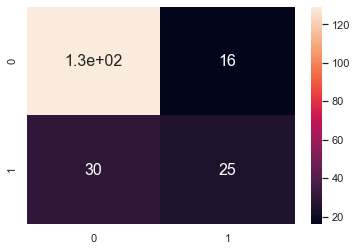

In [12]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
sns.set(font_scale=1) # for label size
#Display the confusion matrix in the form of heatmap
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
#Show the plot
plt.show()

TRAIN: 750 TEST: 250
Accuracy: 0.732
Recall: 0.732
Precision: 0.732
F1-score: 0.6426666666666666


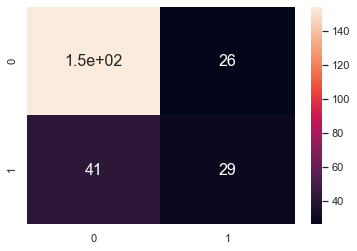

TRAIN: 750 TEST: 250
Accuracy: 0.776
Recall: 0.776
Precision: 0.776
F1-score: 0.6818471048086537


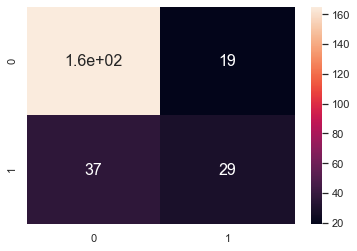

TRAIN: 750 TEST: 250
Accuracy: 0.728
Recall: 0.728
Precision: 0.728
F1-score: 0.6736793611793612


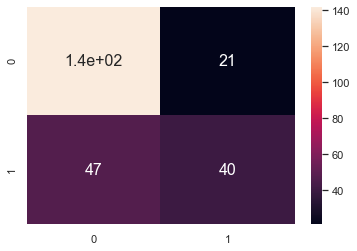

TRAIN: 750 TEST: 250
Accuracy: 0.776
Recall: 0.776
Precision: 0.776
F1-score: 0.7246046109056574


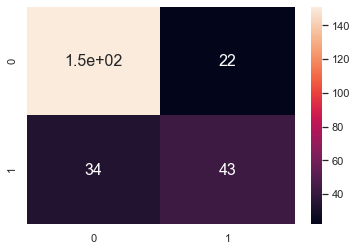

In [14]:
# Implement K-fold validation and compare the perfromance with 80-20 random split (using sklearn methods)
from sklearn.model_selection import KFold
kf = KFold(n_splits=4)

for train_index, test_index in kf.split(X):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = LogisticRegression(penalty='l2',C=1.0, max_iter=10000)
    # Train the classifier until max_iterations
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    precision = precision_score(y_test,y_pred, average='micro')
    recall = recall_score(y_test,y_pred, average='micro')
    accuracy = accuracy_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred, average='macro')

    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1-score: {f1}")
    
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
    sns.set(font_scale=1) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.show()

In [18]:
# Saving the model (to be used in API)
filename = 'model/finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))
 